In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import pandas as pd
import numpy

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

Using TensorFlow backend.


In [2]:
def data(range_):
    precipitation = read_csv('Monthwise_Precipitation.csv')
    sunspot = read_csv('Monthwise_Sunspot.csv')

    sunspot['Date']= pd.to_datetime(sunspot['Date'])
    precipitation['Date']= pd.to_datetime(precipitation['Date'])

    sunspot.set_index('Date', inplace=True)
    precipitation.set_index('Date', inplace=True)

    sunspot = sunspot[range_[0]:range_[1]] #['1951-01-01': '2017-01-01']

    sunspot['year'] = pd.DatetimeIndex(sunspot.index).year
    precipitation['year'] = pd.DatetimeIndex(precipitation.index).year

    sunspot['month'] = pd.DatetimeIndex(sunspot.index).month
    precipitation['month'] = pd.DatetimeIndex(precipitation.index).month

    precipitation = precipitation.asfreq('M', method='bfill')
    sunspot = sunspot.asfreq('M', method='bfill')

    return precipitation, sunspot

# With Sunspot Data

In [3]:
precipitation, sunspot = data(['1942-01-01', '2008-01-01'])

In [4]:
raw_values = precipitation['Precipitation']#series.values
diff_values = difference(raw_values, 12)

supervised = timeseries_to_supervised(diff_values, 1)
supervised[1] = numpy.array(sunspot['Sunspot'][12:])
supervised_values = supervised.values

a = numpy.vstack([supervised_values[:, 0], supervised_values[:, 2]])
supervised_values = numpy.vstack([a, supervised_values[:, 1]]).T

train, test = supervised_values[0:-80], supervised_values[-80:]

1) Test RMSE: 2.44744
2) Test RMSE: 2.45028
3) Test RMSE: 2.44846
4) Test RMSE: 2.45641
5) Test RMSE: 2.45256
6) Test RMSE: 2.45453
7) Test RMSE: 2.45498
8) Test RMSE: 2.45280
9) Test RMSE: 2.44931
10) Test RMSE: 2.45903
            rmse
count  10.000000
mean    2.452580
std     0.003730
min     2.447443
25%     2.449552
50%     2.452683
75%     2.454865
max     2.459028


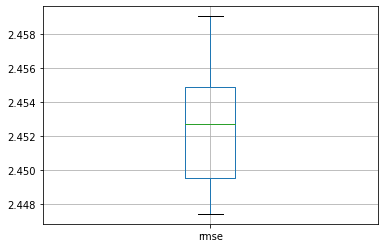

In [5]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
# repeat experiment
repeats = 10
error_scores = list()
for r in range(repeats):
    # fit the model
  lstm_model = fit_lstm(train_scaled, 1, 50, 2)
  # forecast the entire training dataset to build up state for forecasting
  train_reshaped = train_scaled[:, :-1].reshape(len(train_scaled), 1, 2)
  lstm_model.predict(train_reshaped, batch_size=1)
  # walk-forward validation on the test data
  predictions = list()
  for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
  # report performance
  rmse = sqrt(mean_squared_error(raw_values[-80:], predictions))
  print('%d) Test RMSE: %.5f' % (r+1, rmse))
  error_scores.append(rmse)

# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.savefig('LSTM_withX.png')
pyplot.show()

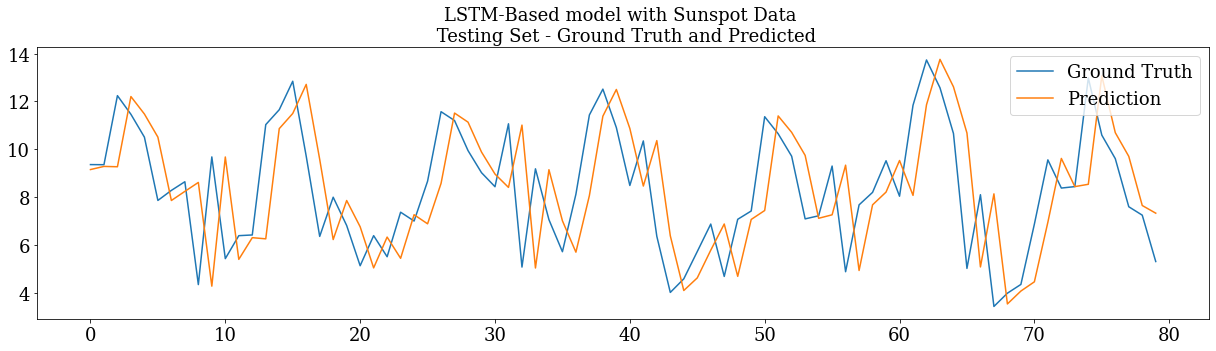

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(21,5))
plt.plot(range(len(raw_values[-80:])),raw_values[-80:],label="Ground Truth")
plt.plot(range(len(predictions)),predictions,label="Prediction")
plt.title("LSTM-Based model with Sunspot Data \n Testing Set - Ground Truth and Predicted")
# plt.savefig("lstm_withX.png")
plt.legend()
plt.show()

# Without Sunspot data

In [9]:
precipitation, sunspot = data(['1951-01-01', '2017-01-01'])

In [10]:
raw_values = precipitation['Precipitation']#series.values
diff_values = difference(raw_values, 12)

supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

train, test = supervised_values[0:-80], supervised_values[-80:]

1) Test RMSE: 2.44967
2) Test RMSE: 2.44997
3) Test RMSE: 2.45192
4) Test RMSE: 2.45394
5) Test RMSE: 2.44970
6) Test RMSE: 2.45121
7) Test RMSE: 2.45266
8) Test RMSE: 2.44898
9) Test RMSE: 2.44995
10) Test RMSE: 2.45140
            rmse
count  10.000000
mean    2.450940
std     0.001566
min     2.448982
25%     2.449763
50%     2.450590
75%     2.451793
max     2.453936


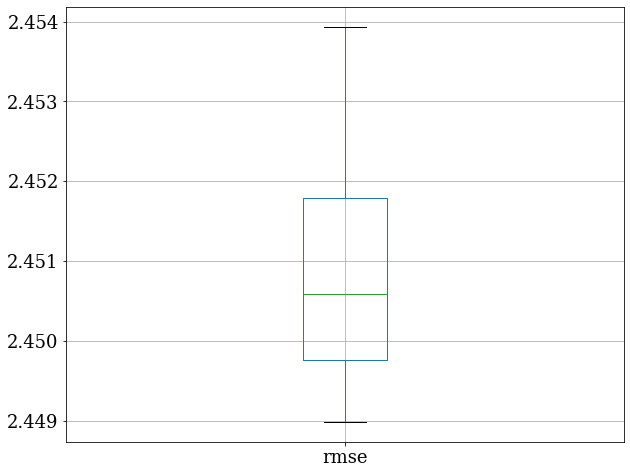

In [11]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
# repeat experiment
repeats = 10
error_scores = list()
for r in range(repeats):
    # fit the model
  lstm_model = fit_lstm(train_scaled, 1, 50, 1)
  # forecast the entire training dataset to build up state for forecasting
  train_reshaped = train_scaled[:, :-1].reshape(len(train_scaled), 1, 1)
  lstm_model.predict(train_reshaped, batch_size=1)
  # walk-forward validation on the test data
  predictions = list()
  for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
  # report performance
  rmse = sqrt(mean_squared_error(raw_values[-80:], predictions))
  print('%d) Test RMSE: %.5f' % (r+1, rmse))
  error_scores.append(rmse)
  
# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.savefig('LSTM_withoutX.png')
pyplot.show()

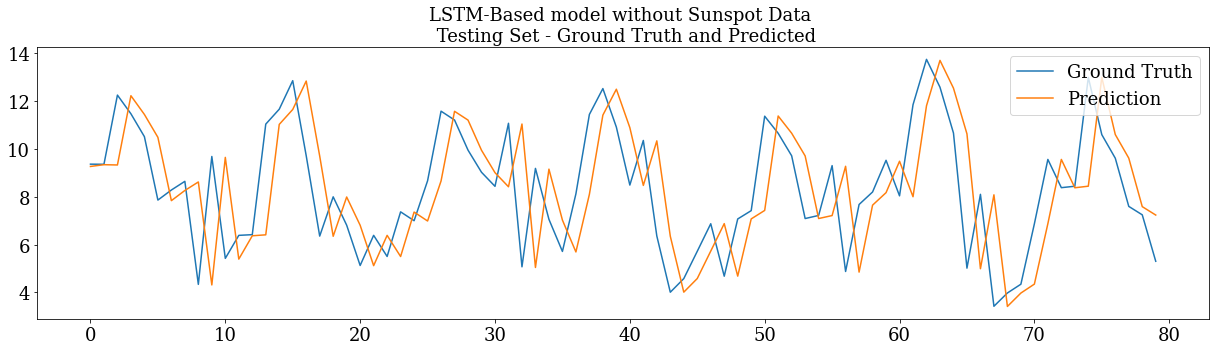

In [12]:
plt.figure(figsize=(21,5))
plt.plot(range(len(raw_values[-80:])),raw_values[-80:],label="Ground Truth")
plt.plot(range(len(predictions)),predictions,label="Prediction")
plt.title("LSTM-Based model without Sunspot Data \n Testing Set - Ground Truth and Predicted")
plt.savefig("lstm_withoutX.png")
plt.legend()
plt.show()